In [1]:
project_path = "X:/Asmara/"
base_atom = "O"

elastic_line = [ 4.555359e-03 , 5.162874e+02 ] #[energy_per_pixel, energy_zero]


In [2]:
%pylab agg
%matplotlib nbagg

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.signal import find_peaks
# from scipy.optimize import curve_fit


Populating the interactive namespace from numpy and matplotlib


In [3]:
xas_dict = {}


def load_xas(scan_number, path=project_path.replace("\\", "/"), base=base_atom):

    global xas_dict
    if scan_number not in xas_dict:
        xas = {}
        data = np.loadtxt(f"{path}/XAS/{base}_{scan_number:04d}.xas", comments="#")
        xas["EN"] = data[:, 0]
        xas["TEY"] = data[:, 1]
        xas["TFY"] = data[:, 2]
        xas["RMU"] = data[:, 3]
        xas_dict[scan_number] = xas
    else:
        xas = xas_dict[scan_number]

    return xas["EN"], xas["TEY"], xas["TFY"], xas["RMU"]


In [4]:
rixs_dict = {}


def load_h5(file_name):

    f = h5py.File(file_name, "r")
    ccd = np.array(f["entry"]["analysis"]["spectrum"][()])
    f.close()

    return ccd


def load_ccds(scan_number, path=project_path.replace("\\", "/"), base=base_atom):

    global rixs_dict
    if scan_number not in rixs_dict:
        rixs = {}
        for i in range(1, 4):
            rixs[i] = load_h5(f"{path}/RIXS/{base}_{scan_number:04d}_d{i}.h5")
        rixs_dict[scan_number] = rixs
    else:
        rixs = rixs_dict[scan_number]

    return rixs[1], rixs[2], rixs[3]


In [5]:
def x_corr(refData, uncorrData):

    corr = correlate(refData, uncorrData)
    lag = np.argmax(corr)
    corrData = np.roll(uncorrData, lag)

    return corrData


def elastic_shift(xdata_pixel, ydata_pixel, ei, el = elastic_line):
    
    if ei == None:
        xdata_energy = xdata_pixel * el[0] + el[1]
        ydata_energy = ydata_pixel
    else:
        xdata_energy = xdata_pixel * el[0] + el[1] - ei
        
        zero = int((ei - el[1]) / el[0])
        xdata_energy = xdata_energy[(zero - 2000) : (zero + 200)]
        ydata_energy = ydata_pixel[(zero - 2000) : (zero + 200)]

    return xdata_energy, ydata_energy



In [6]:
def load_rix(scan_number):

    ccd1, ccd2, ccd3 = load_ccds(scan_number)
    ccd1 = x_corr(ccd2, ccd1)
    ccd3 = x_corr(ccd2, ccd3)

    #    load raw data
    xdata = np.arange(len(ccd2))
    ydata = ccd1 + ccd2 + ccd3

    # shift elastic peaks
    # xdata,ydata = elastic_shift(xdata,ydata)
    
    return xdata, ydata


def load_rixs(scans, ei = None):
    if type(scans) is int:
        xdata,ydata = load_rix(scans)
        # normalize data
        # ydata = ydata/3
    else:
        for i, scan_number in enumerate(scans):
            if i == 0:
                xdata, onedata = load_rix(scan_number)
                refdata = onedata
                ydata = onedata
            else:
                _, onedata = load_rix(scan_number)
                onedata = x_corr(refdata, onedata)
                ydata = ydata + onedata

        # normalize data
        # ydata = ydata/len(scans)/3
        
    # shift elastic peaks
    xdata,ydata = elastic_shift(xdata,ydata,ei)
    
    return xdata, ydata



In [7]:
def plot_map(run_list,Y = None):
    run_num = len(run_list)
    if Y is None:
        yaxis = np.arange(run_num+1)
        xaxis,_ = load_rixs(run_list[0])
        data = np.zeros((run_num,len(xaxis)))
        for i,runs in enumerate(run_list):
            _,d = load_rixs(runs)
            data[i,:] = d
    else:
        yaxis = np.linspace(Y[0],Y[1],run_num)
        xaxis,_ = load_rixs(run_list[0],Y[0])
        data = np.zeros((run_num,len(xaxis)))
        for i,runs in enumerate(run_list):
            _,d = load_rixs(runs,yaxis[i])
            data[i,:] = d
            
    fig,ax = plt.subplots()
    im = ax.pcolorfast(xaxis,(yaxis[0]*1.5-yaxis[1]*0.5 , yaxis[-1]*1.5-yaxis[-2]*0.5),data)
    fig.colorbar(im)
    ax.set_xlabel('Energy Loss ( eV )')
    
    return fig,ax,im


## Example to plot XAS data

<IPython.core.display.Javascript object>


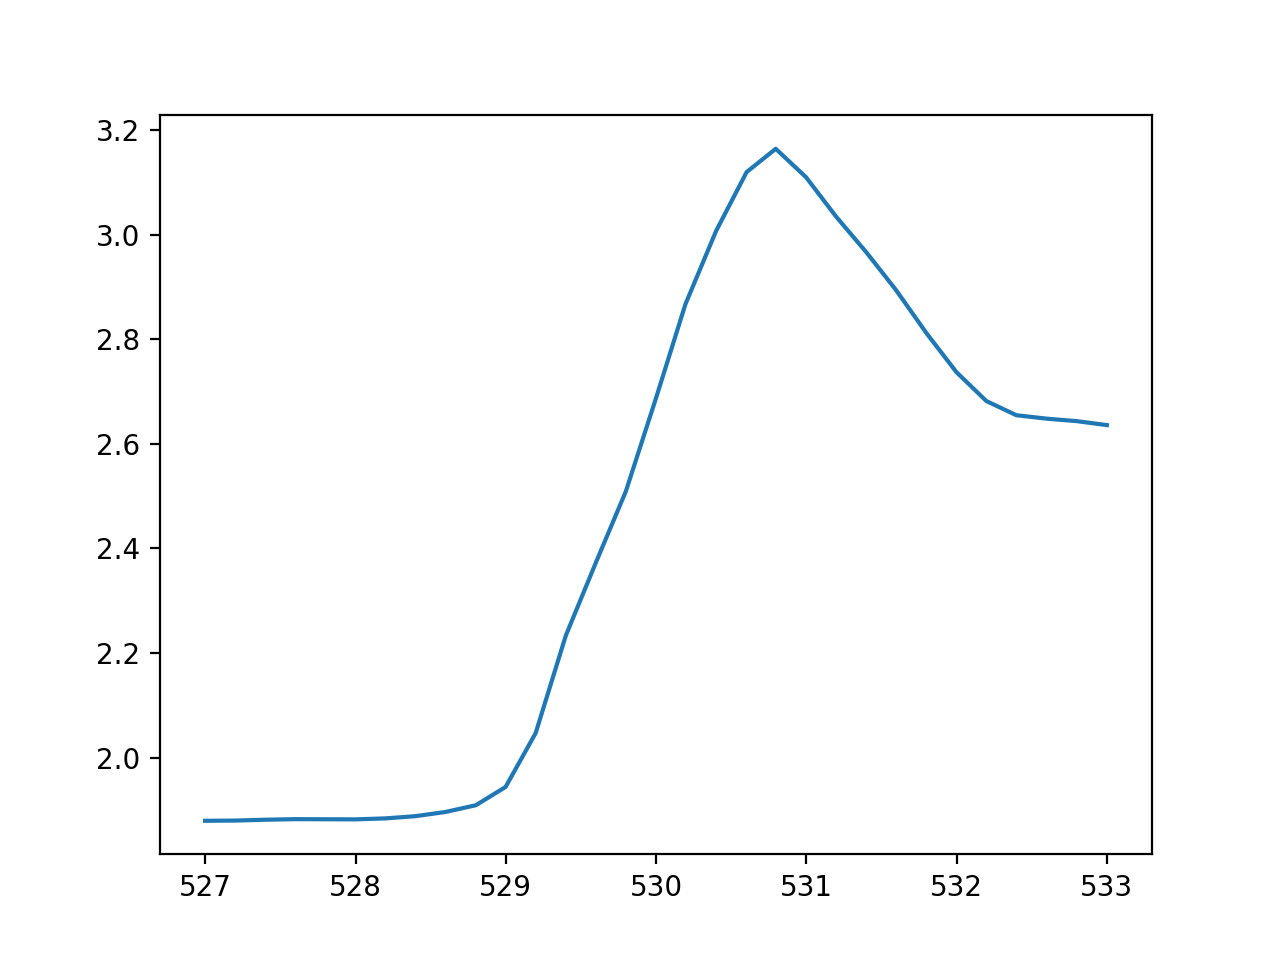

In [8]:
figure()
EN, TEY, TFY, RMU = load_xas(2)
plot(EN, TEY)


## Example to plot one RIXS acquire

<IPython.core.display.Javascript object>


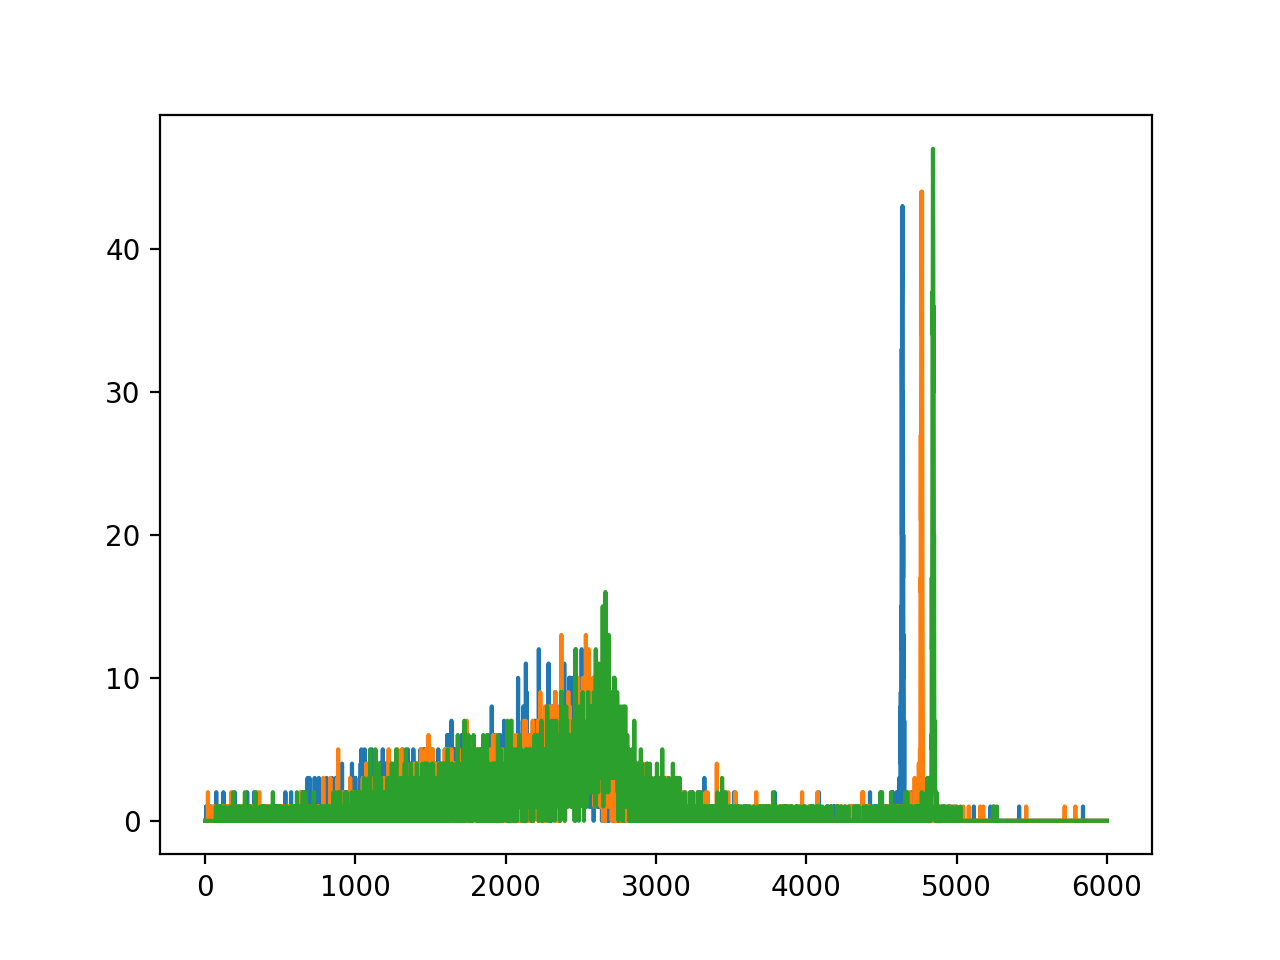

In [9]:
figure()
d1, d2, d3 = load_ccds(28)
plot(d1)
plot(d2)
plot(d3)


## Example to combine and plot repeating RIXS data

<IPython.core.display.Javascript object>


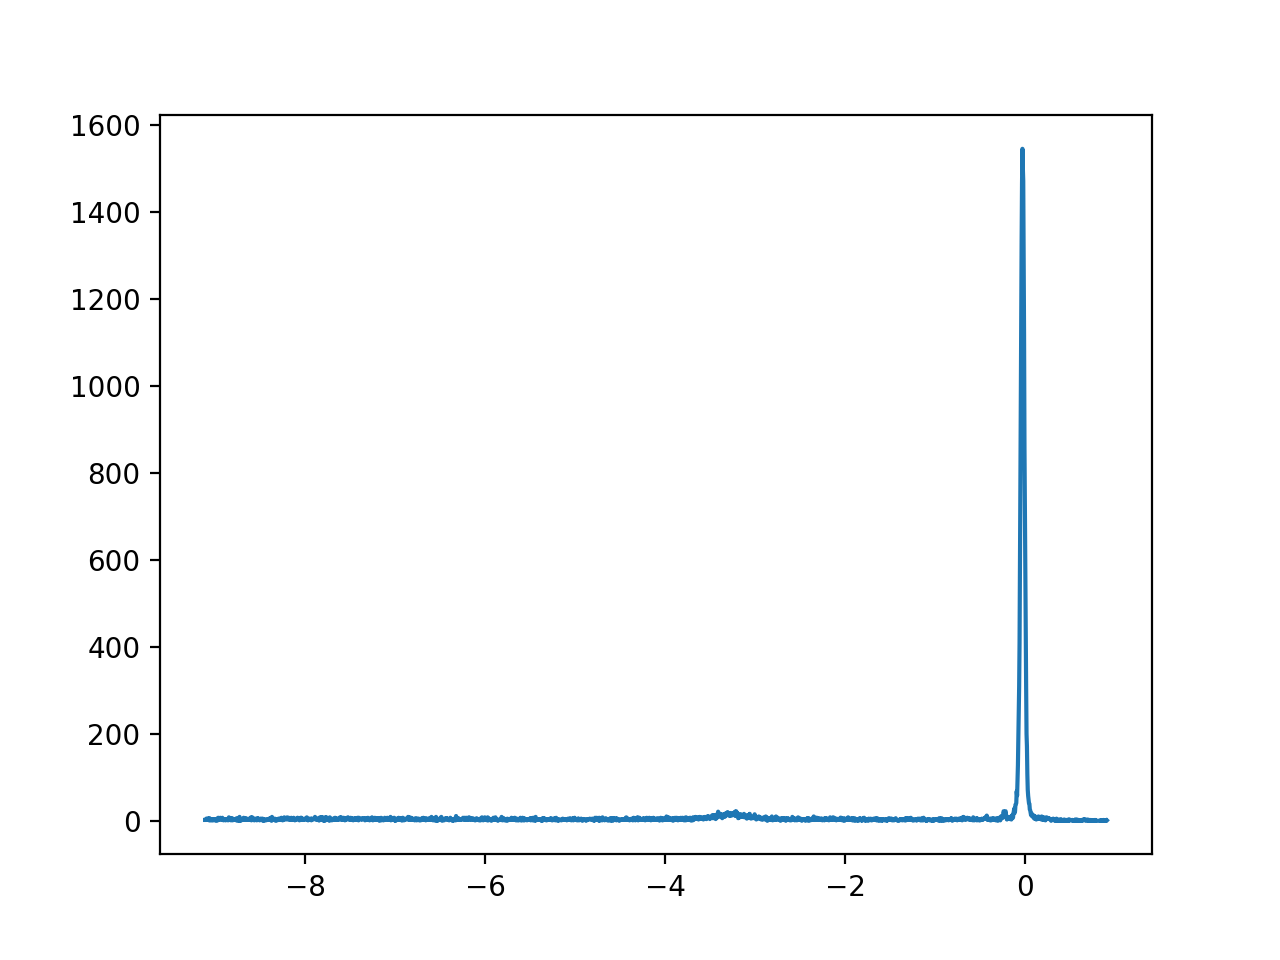

In [10]:
figure()
X, Y = load_rixs([18, 19, 20, 21], ei = 528)
plot(X, Y)


<IPython.core.display.Javascript object>


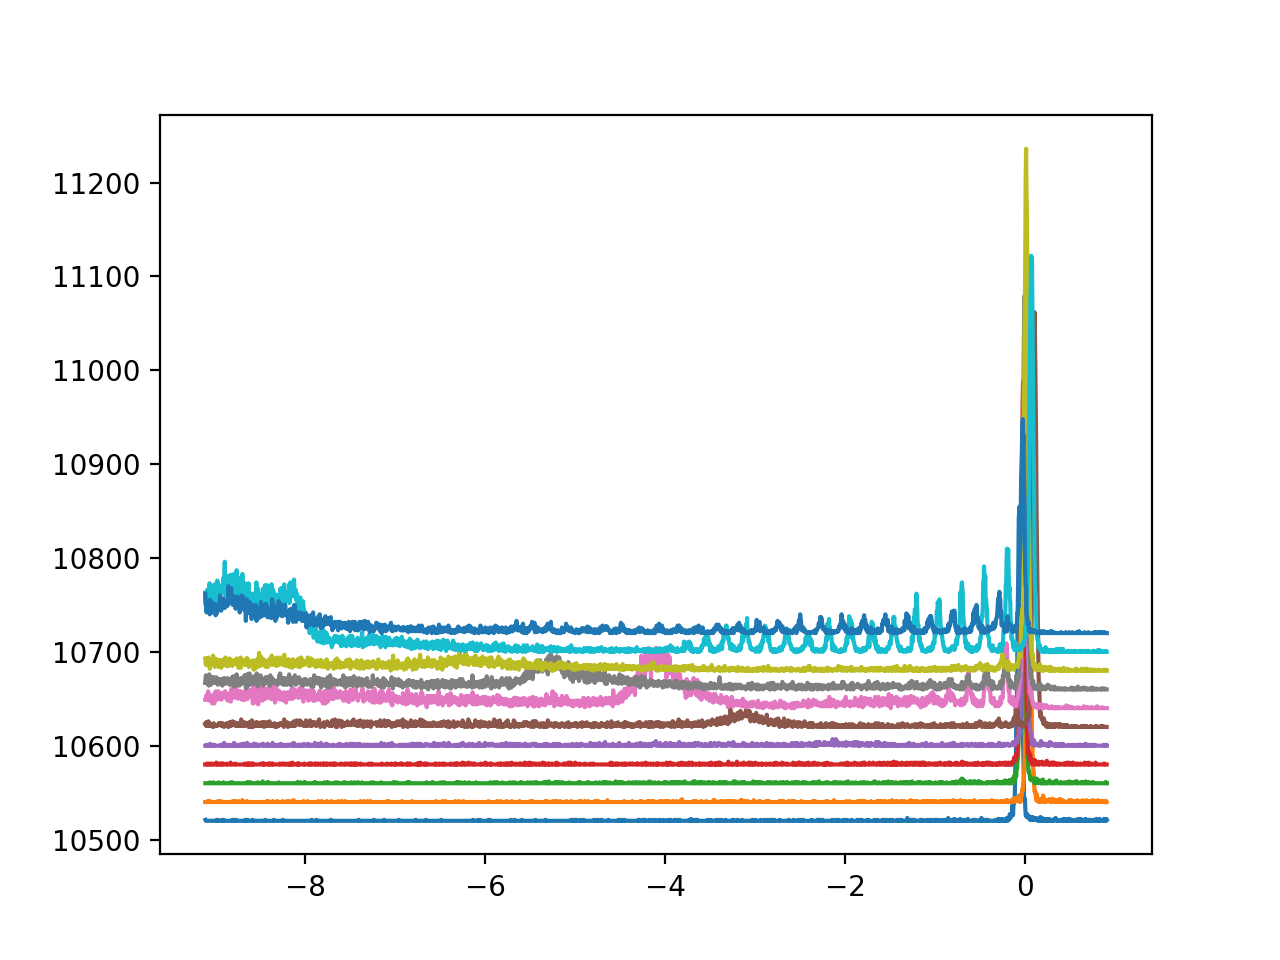

In [11]:
figure()

for run,ei in zip(range(16,26+1) , range(526,538+1)):
    X, Y = load_rixs(run, ei)
    plot(X, Y + ei*20)

## Example to map squence

<IPython.core.display.Javascript object>


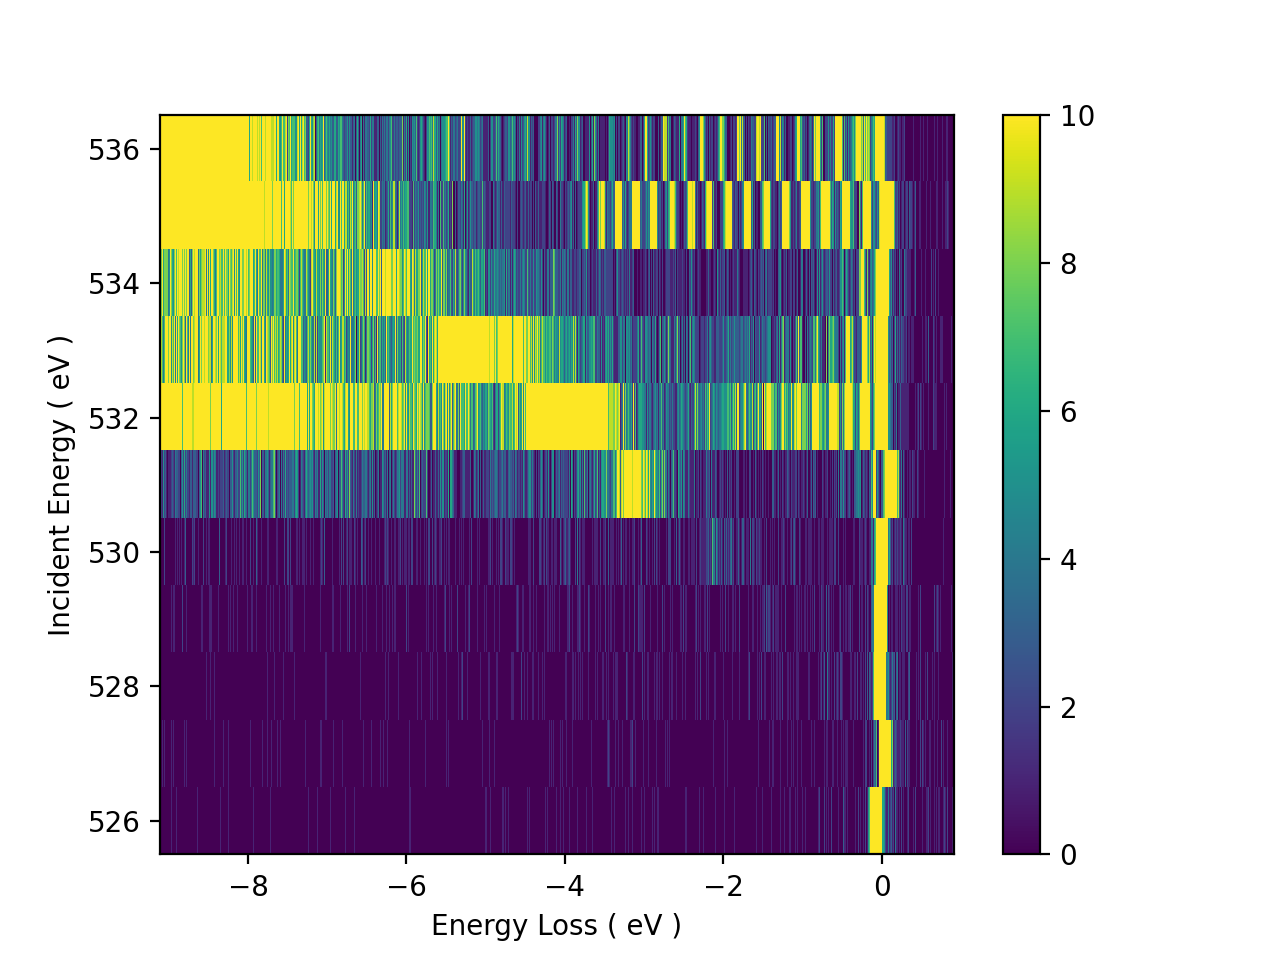

Text(0, 0.5, 'Incident Energy ( eV )')

In [12]:
run_list = range(16,26+1)
fig,ax,im = plot_map(run_list,Y=(526,536))
im.set_clim(0,10)
ax.set_ylabel('Incident Energy ( eV )')